In [34]:
from datetime import datetime, timedelta
import os
import imageio
from matplotlib.colors import LinearSegmentedColormap
from cartopy.crs import PlateCarree
import matplotlib.pyplot as plt
from herbie import Herbie
from toolbox import EasyMap, pc
import warnings

# Suppress the specific warning
warnings.filterwarnings('ignore', 'This pattern is interpreted as a regular expression')


In [23]:
# Data Checker - Lists available data for the current date and hourly run you choose
init_date = datetime.strptime("2023-10-17 0", "%Y-%m-%d %H")

available_fxx = []

# Loop through potential forecast hours every 3 hours
for fxx in range(0, 240, 3):  # Now stepping in intervals of 3
    try:
        H_temp = Herbie(
            init_date.strftime("%Y-%m-%d %H"),
            model="ecmwf",
            product="oper",
            fxx=fxx
        )
        
        # Attempt to retrieve the data
        ds = H_temp.xarray(":(q|gh):500", remove_grib=False)
        
        # Check if valid_time has duplicates and deduplicate if necessary
        if 'valid_time' in ds.coords and ds['valid_time'].size > 1:
            _, index = np.unique(ds['valid_time'], return_index=True)
            ds = ds.isel(valid_time=index)
        
        # If successful, add the current fxx to the list
        available_fxx.append(fxx)
    except:
        # If there's an error (likely data not found), print a message
        print(f"Data not found for forecast hour F{fxx:02}")
        continue

fxx_range = available_fxx
print(ds)


✅ Found ┊ model=ecmwf ┊ product=oper ┊ 2023-Oct-17 00:00 UTC F00 ┊ GRIB2 @ azure ┊ IDX @ azure
✅ Found ┊ model=ecmwf ┊ product=oper ┊ 2023-Oct-17 00:00 UTC F03 ┊ GRIB2 @ azure ┊ IDX @ azure
✅ Found ┊ model=ecmwf ┊ product=oper ┊ 2023-Oct-17 00:00 UTC F06 ┊ GRIB2 @ azure ┊ IDX @ azure
✅ Found ┊ model=ecmwf ┊ product=oper ┊ 2023-Oct-17 00:00 UTC F09 ┊ GRIB2 @ azure ┊ IDX @ azure
✅ Found ┊ model=ecmwf ┊ product=oper ┊ 2023-Oct-17 00:00 UTC F12 ┊ GRIB2 @ azure ┊ IDX @ azure
✅ Found ┊ model=ecmwf ┊ product=oper ┊ 2023-Oct-17 00:00 UTC F15 ┊ GRIB2 @ azure ┊ IDX @ azure
✅ Found ┊ model=ecmwf ┊ product=oper ┊ 2023-Oct-17 00:00 UTC F18 ┊ GRIB2 @ azure ┊ IDX @ azure
✅ Found ┊ model=ecmwf ┊ product=oper ┊ 2023-Oct-17 00:00 UTC F21 ┊ GRIB2 @ azure ┊ IDX @ azure
✅ Found ┊ model=ecmwf ┊ product=oper ┊ 2023-Oct-17 00:00 UTC F24 ┊ GRIB2 @ azure ┊ IDX @ azure
✅ Found ┊ model=ecmwf ┊ product=oper ┊ 2023-Oct-17 00:00 UTC F27 ┊ GRIB2 @ azure ┊ IDX @ azure
✅ Found ┊ model=ecmwf ┊ product=oper ┊ 2023-Oct-17

✅ Found ┊ model=ecmwf ┊ product=oper ┊ 2023-Oct-17 00:00 UTC F00 ┊ GRIB2 @ azure ┊ IDX @ azure
✅ Found ┊ model=ecmwf ┊ product=oper ┊ 2023-Oct-17 00:00 UTC F06 ┊ GRIB2 @ azure ┊ IDX @ azure
✅ Found ┊ model=ecmwf ┊ product=oper ┊ 2023-Oct-17 00:00 UTC F12 ┊ GRIB2 @ azure ┊ IDX @ azure
✅ Found ┊ model=ecmwf ┊ product=oper ┊ 2023-Oct-17 00:00 UTC F18 ┊ GRIB2 @ azure ┊ IDX @ azure
✅ Found ┊ model=ecmwf ┊ product=oper ┊ 2023-Oct-17 00:00 UTC F24 ┊ GRIB2 @ azure ┊ IDX @ azure
✅ Found ┊ model=ecmwf ┊ product=oper ┊ 2023-Oct-17 00:00 UTC F30 ┊ GRIB2 @ azure ┊ IDX @ azure
✅ Found ┊ model=ecmwf ┊ product=oper ┊ 2023-Oct-17 00:00 UTC F36 ┊ GRIB2 @ azure ┊ IDX @ azure
✅ Found ┊ model=ecmwf ┊ product=oper ┊ 2023-Oct-17 00:00 UTC F00 ┊ GRIB2 @ azure ┊ IDX @ azure
✅ Found ┊ model=ecmwf ┊ product=oper ┊ 2023-Oct-17 00:00 UTC F06 ┊ GRIB2 @ azure ┊ IDX @ azure
✅ Found ┊ model=ecmwf ┊ product=oper ┊ 2023-Oct-17 00:00 UTC F12 ┊ GRIB2 @ azure ┊ IDX @ azure
✅ Found ┊ model=ecmwf ┊ product=oper ┊ 2023-Oct-17

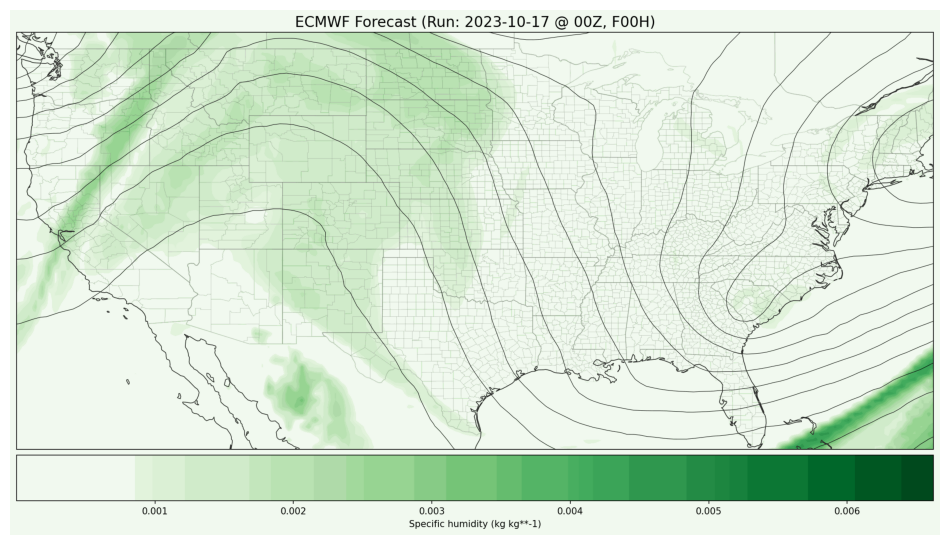

In [36]:
# init_date = datetime.strptime("2023-10-17 0", "%Y-%m-%d %H")
frames = []

# Initialize global min and max for colorbar scaling
global_min = float('inf')
global_max = float('-inf')

# First loop to find global min and max
for fxx in range(0, 42, 6):  
    try:
        H = Herbie(
            init_date.strftime("%Y-%m-%d %H"),
            model="ecmwf",
            product="oper",
            fxx=fxx
        )
        ds = H.xarray(":(q|gh):500", remove_grib=False)
        
        local_min = ds.q.min().values
        local_max = ds.q.max().values
        global_min = min(global_min, local_min)
        global_max = max(global_max, local_max)
    except Exception as e:
        print(f"Error for fxx={fxx}: {e}")
        continue

# Main loop for generating frames
for fxx in range(0, 42, 6):  
    try:
        H = Herbie(
            init_date.strftime("%Y-%m-%d %H"),
            model="ecmwf",
            product="oper",
            fxx=fxx
        )

        ds = H.xarray(":(q|gh):500")

        if 'valid_time' in ds.coords and ds['valid_time'].size > 1:
            _, index = np.unique(ds['valid_time'], return_index=True)
            ds = ds.isel(valid_time=index)
        
        ax = EasyMap("50m", crs=PlateCarree(), figsize=[17.99, 10.59]).STATES().OCEAN().LAND().COUNTIES().ax
        ax.set_extent([-125, -70, 25, 50], crs=PlateCarree())

        # Color shade by specific humidity (set vmin and vmax)
        p = ax.imshow(
        ds.q, 
        transform=pc, 
        cmap="Greens",
        vmin=global_min, 
        vmax=global_max,
        interpolation='bilinear',  # Smoothing
        extent=[ds.longitude.min(), ds.longitude.max(), ds.latitude.min(), ds.latitude.max()]
        )

        plt.colorbar(
            p,
            ax=ax,
            orientation="horizontal",
            pad=0.01,
            label=f"{ds.q.GRIB_name} ({ds.q.units})"
        )

        ax.contour(
            ds.longitude,
            ds.latitude,
            ds.gh,
            transform=pc,
            colors="k",
            linewidths=0.5,
            levels=range(5000, 6000, 40)
        )

        ax.set_title(f"ECMWF Forecast (Run: {init_date.strftime('%Y-%m-%d @ %H')}Z, F{fxx:02}H)", fontsize=16)

        frame_filename = f"temp_frame_{fxx}.png"
        plt.savefig(frame_filename, dpi=150, bbox_inches='tight', pad_inches=0.1)
        frames.append(frame_filename)

        plt.close()

    except Exception as e:
        print(f"Error for fxx={fxx}: {e}")
        continue

# Combine individual frames into a GIF
import imageio.v2 as imageio_v2

with imageio_v2.get_writer('ecmwf_forecast.gif', mode='I', duration=500, loop=0) as writer:
    for frame_filename in frames:
        image = imageio_v2.imread(frame_filename)
        writer.append_data(image)

# Clean up individual frame files
for frame_filename in frames:
    os.remove(frame_filename)

# Display the generated GIF
plt.figure(figsize=(12, 12))
plt.imshow(imageio_v2.imread('ecmwf_forecast.gif'))
plt.axis('off')
plt.show()